In [1]:
from __future__ import division, print_function, absolute_import

import sqlite3
import tflearn as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
conn = sqlite3.connect('surge_data.db')
c = conn.cursor()

In [3]:
point_list = [0, 1, 2, 3, 14, 15, 16, 12, 13, 24, 25, 26, 27, 28, 17, 29]

sql_output = np.array([np.array(pd.read_sql\
                ('''SELECT surge FROM surge WHERE point = {} ORDER BY date LIMIT 31184'''.format(point), conn)).T\
                  for point in point_list])[:,0,:].T

# this gets run when I'm done working for the session
conn.close()

In [4]:
steps_of_history = 30
steps_in_future = 5

y = sql_output[steps_of_history+steps_in_future-1:,:]
X = sql_output[:len(y),:]
my_x = np.empty([len(y),steps_of_history,16])

for i, _ in enumerate(X):
    time_chunk = X[i:i+steps_of_history,:]
    if time_chunk.shape == (steps_of_history, 16):
        my_x[i,:,:] = time_chunk
    else:
        my_x[i,:,:] = np.ones((steps_of_history,16))

trainX, testX = my_x[:-1000,:], my_x[-1000:,:]
trainY, testY = y[:-1000,:], y[-1000:,:]

In [5]:
# Build my neural net
net = tf.input_data(shape=[None, steps_of_history, 16])
net = tf.lstm(net, n_units=128,activation='softsign', return_seq=False)
# net = tf.dropout(net, 0.5)

# net = tflearn.lstm(net, 128, return_seq=False)
# net = tflearn.dropout(net, 0.5)

net = tf.fully_connected(net, 16, activation='linear')
net = tf.regression(net, optimizer='sgd', loss='mean_square', learning_rate=0.3)

In [6]:
# Training
model = tf.DNN(net, clip_gradients=0.0, tensorboard_verbose=0)
model.fit(trainX, trainY, n_epoch=130, validation_set=0.1, batch_size=128)

Training Step: 27560  | total loss: 0.02255
| SGD | epoch: 130 | loss: 0.02255 | val_loss: 0.02359 -- iter: 27135/27135
Training Step: 27560  | total loss: 0.02255
| SGD | epoch: 130 | loss: 0.02255 | val_loss: 0.02359 -- iter: 27135/27135
--


In [7]:
predictY = np.array(model.predict(testX))

In [8]:
# when the model forecasts that the surge will be LESS than 1 I correct it to say it is 1
corrected_predictions = np.zeros(predictY.shape)

for i, time in enumerate(predictY):
    for j, point in enumerate(time):
        if point <=1.03:
            corrected_predictions[i,j] = 1.0
        else:
            corrected_predictions[i,j] = point

In [9]:
np.mean((predictY - testY)**2), np.mean((corrected_predictions - testY)**2)
# 0.0.037310431073829413 dropout
# 0.041944119153735963 dropout
# 0.040086058746032424 dropout

# 0.037250095711874931 no dropout
# 0.035859382629193741 no dropout
# 0.039359871432686842 no dropout
# 0.034820710072402519 no dropout

# 0.032177727069074825 no dropout epoch=50

# 0.029624470953246568 no dropout epoch=60
# 0.032012765336614804 no dropout epoch=60


# 0.031938012845315222 no dropout epoch=70
# 0.031631535189401538 no dropout epoch=70

# 0.030035572519224285 no dropout epoch=80

# 0.031561734949849297 no dropout epoch=90

# 0.031121756295468535 no dropout epoch=110

# 0.02967024115169831 no dropout epoch=130

(0.02967024115169831, 0.029230970925593312)

In [10]:
predictY = corrected_predictions

In [14]:
def graph_em(test, forecast, graph_name):
    subs = {0:811, 1:812, 2:813, 3:814, 4:815, 5:816, 6:817, 7:818}
    plt.figure(figsize=(20,25))
    for i, point in enumerate(test.T):
        plt.subplot(subs[i])
        plt.title('History='+str(steps_of_history)+', Future='+str(steps_in_future))
        plt.plot(point, 'k-', label='Actual')
        plt.plot(forecast[:,i], 'c-', label='Forecast')
        plt.legend()
        
    plt.savefig(graph_name, bbox_inches='tight', dpi=300)
    plt.show()

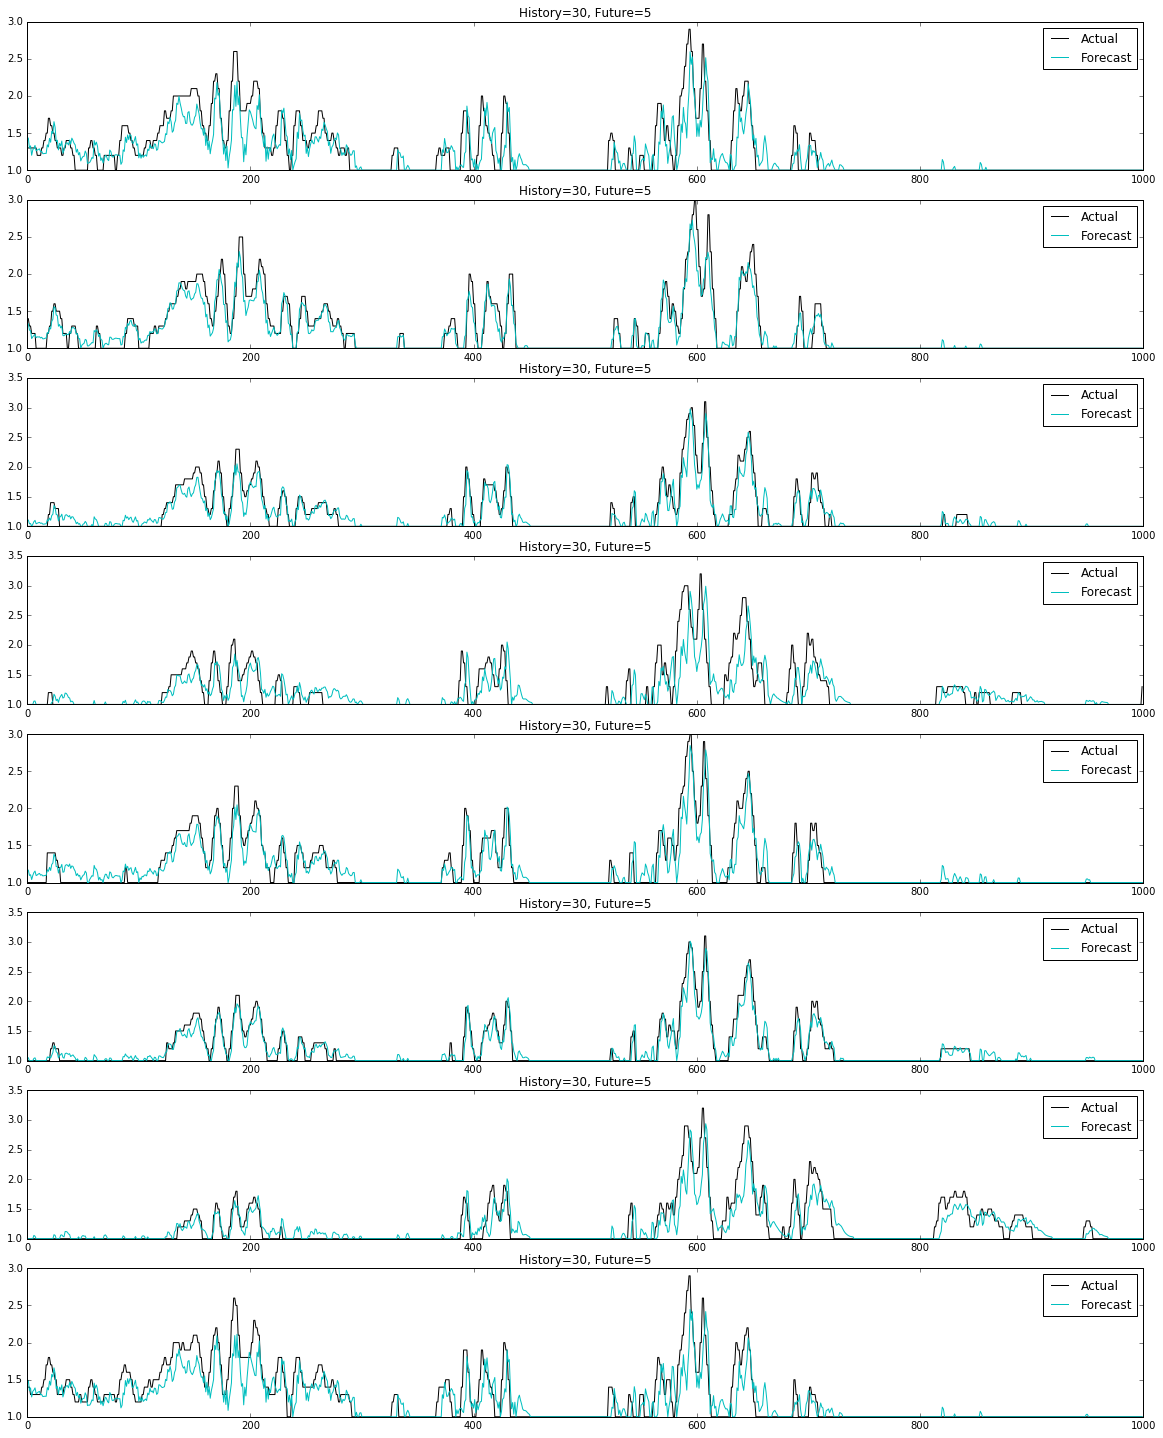

In [15]:
graph_em(testY[:,:8], predictY[:,:8], 'forecast_1.png')

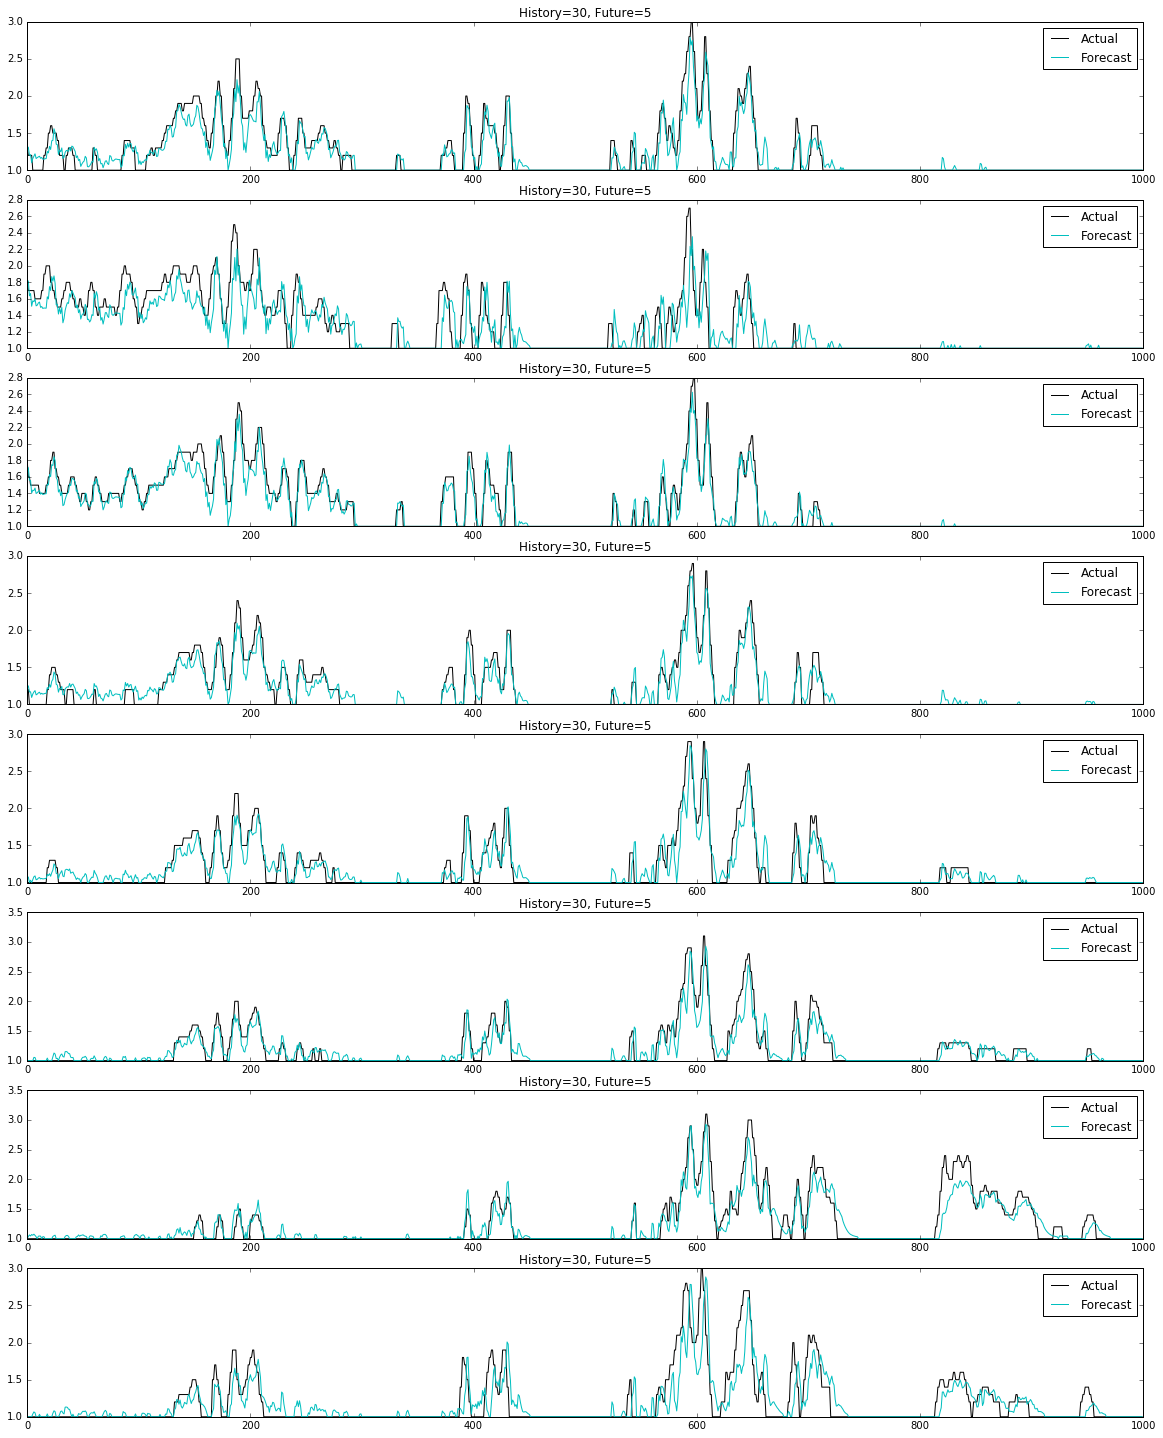

In [16]:
graph_em(testY[:,8:], predictY[:,8:], 'forecast_2.png')